# 3. Construction du graphe

In [8]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Récupérer le fichier des utilisateurs

Le code exécuté dans le graphe précédent a permis de générer trois fichiers. On a rassemblé manuellement ces trois fichiers pour créer un nouveau fichier concaténé à partir duquel on génère le graphe qui sert de base à l'analyse. 

In [9]:
f = open("followers_list_complet.txt", 'r')    #Fichier assemblé manuellement
following_dictionnary = {}
for line in f:
    rows=line.split('\t')
    rows=rows[:-1]
    following_dictionnary[rows[0]]=[r for r in rows[1:]]

f.close()

## Construction du graphe

#### Création du graphe

In [10]:
#Générer les arêtes

def generate_edges(graph):
    edges = []

    # for each node in graph
    for node in graph:

        # for each neighbour node of a single node
        for neighbour in graph[node]:
            # if edge exists then append
            edges.append((node, neighbour))
    return edges

In [11]:
#Créer la liste des arêtes
list_edges=generate_edges(following_dictionnary)

In [12]:
#Isoler les noeuds du graphe
head=list(following_dictionnary.keys())

nodes=[]

for key in following_dictionnary.keys():
    for item in range(len(following_dictionnary[key])):
        nodes.append(following_dictionnary[key][item])
        
for k in range(len(head)):
    nodes.append(head[k])

nodes = list(dict.fromkeys(nodes))
nodes.remove(nodes[nodes.index('')])

In [13]:
len(nodes)
len(list_edges)

270105

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(list_edges)

#### Visualisation du graphe

<b> PARTIE A COMPLETER </b>

On propose dans cette section quelques représentations du graphe.

In [15]:
small_nodes=nodes[:10]   #Pire moyen de sélectionner les noeuds. Prendre ceux autour d'un influenceur au moins
sub_g = g.subgraph(small_nodes)

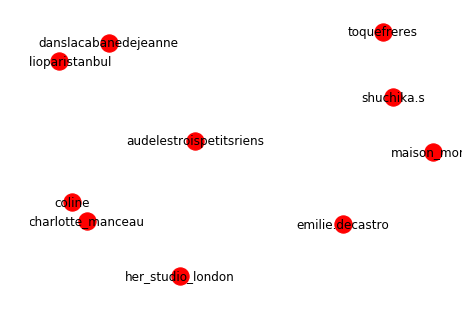

In [16]:
graph_pos = nx.random_layout(sub_g)   #Essayer jusqu'à avoir un truc joli. 
nx.draw(sub_g,graph_pos,with_labels=True)

plt.draw()
plt.show()

## Statistiques descriptives

On présente dans cette section quelques statistiques descriptives concernant notre graphe.

Densité (pour un graphe orienté) : $d = \frac{m}{n(n-1)},$
where $n$ is the number of nodes and $m$ is the number of edges in $G$.

In [17]:
nx.density(g)

8.056631189385391e-06

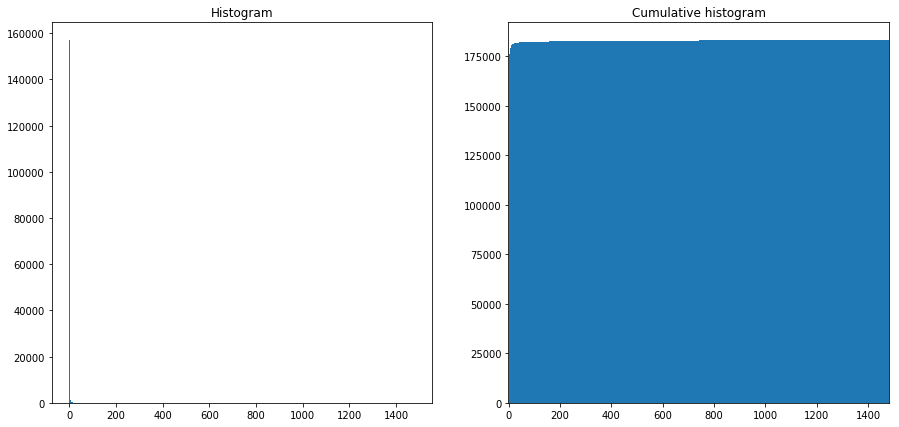

In [18]:
from scipy import stats
import numpy as np

# Graphe avec l'histogramme des degrés et les degrés cumulés

samples=list(dict(nx.degree(g)).values())   #Valeurs
x=[k for k in range(max(samples))]    #Support
res = stats.cumfreq(samples, numbins=max(samples))   #Fréquences cumulées
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,res.cumcount.size)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(samples, bins=max(samples))
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount, width=res.binsize)
ax2.set_title('Cumulative histogram')
ax2.set_xlim([x.min(), x.max()])

plt.show()

On remarque que la grande majorité des noeuds ont un degré faible. C'est cohérent avec la faible densité du graphe. 

In [20]:
from scipy import stats
import statistics as stat

print('Moyenne')
print(stat.mean(samples))
print('Std dev')
print(stat.stdev(samples))
print('Médiane')
print(stat.median(samples))

print(max(samples))


print('Quantiles')

print('75th centile : ',stats.scoreatpercentile(samples, 75))
print('90th centile : ',stats.scoreatpercentile(samples, 90))

for i in range(90,100):
    print(i,'th centile : ',stats.scoreatpercentile(samples, i))



Moyenne
2.9503222282905517
Std dev
27.132332852945154
Médiane
1.0
1481
Quantiles
75th centile :  1.0
90th centile :  2.0
90 th centile :  2.0
91 th centile :  2.0
92 th centile :  2.0
93 th centile :  3.0
94 th centile :  3.0
95 th centile :  4.0
96 th centile :  4.0
97 th centile :  6.0
98 th centile :  9.0
99 th centile :  18.0


La concentration se confirme lorsqu'on regarde les quantiles. Le 99e centile est par exemple 18.

In [13]:
degrees=dict(nx.degree(g))

In [14]:
last_centile={}

pct99=stats.scoreatpercentile(samples, 99)

for user in list(degrees.keys()):
    if degrees[user]>=pct99 :
        last_centile[user] = degrees[user]
        
len(list(last_centile))   #Pour se donner un critère de sélection avec les mesures de centralité

1846

## Sélection des points centraux du graphe

### Construction des indicateurs 

A partir du graphe que nous avons généré, nous allons chercher à isoler les points centraux. On utilise deux critères, le Page Rank et la centralité de vecteur propre. Pour une présentation plus détaillée, voir le document rendu.

In [15]:
eigenvec_centrality=nx.eigenvector_centrality(g, max_iter=1000)

In [16]:
page_rank=nx.pagerank(g, alpha=.9)

In [17]:
del eigenvec_centrality['']
del page_rank['']

In [18]:
# apparté : on regarde quel est le point le plus influent du graphe selon les critères
# on retrouve sans surprise le compte à partir duquel on a généré la liste d'utilisateurs à scrapper

print(max(zip(eigenvec_centrality.values(),eigenvec_centrality.keys())))
print(max(zip(page_rank.values(),page_rank.keys())) )

(0.06899352762452783, 'bestofvanity')
(6.325152225142031e-05, 'coline')


In [19]:
from heapq import nlargest

# On récupère l'équivalent du dernier centile le plus influent (facilite les comparaisons)

largest = nlargest(len(list(last_centile)), eigenvec_centrality, key=eigenvec_centrality.__getitem__)  
dict_largest={item :eigenvec_centrality[item] for item in largest}

largest2 = nlargest(len(list(last_centile)), page_rank, key=page_rank.__getitem__)  
dict_largest2={item :page_rank[item] for item in largest2}

In [20]:
# Comparer avec le dernier centile

share_centile=[0,0]

for (usr,usr2) in zip(largest,largest2):
    
    if usr in list(last_centile):
        share_centile[0]+=1
    if usr2 in list(last_centile):
        share_centile[1]+=1

share_centile=[shares/len(list(last_centile)) for shares in share_centile]
        
share_centile

[0.11213434452871072, 0.356988082340195]

On remarque que la centralité de vecteur propre retient 11% du dernier centile, pour 35% pour le PageRank. Ce ne sont donc pas uniquement les plus "gros" comptes qui sont pris en compte. 

On va à présent supprimer des listes les utilisateurs populaires.

### Suppression des comptes populaires et description

#### Suppression des comptes populaires

Pour supprimer les comptes populaires, on récupère les 1000 comptes français et internationaux les plus influents selon hypeauditor. On les supprime de nos listes, car on considère que ces comptes ne sont pas spécifiquement populaires au sein de la communauté que l'on a ciblé. 

In [21]:
# Suppression des comptes de célébrités françaises et mondiales  
# à partir des bases de données d'influenceurs les plus en vogue : 2 fois 1000 premiers comptes sur hypeauditor

!python top_charts.py

with open('charts.txt') as f:
    init_file = list(f)
init_file = init_file[0]
celebs=init_file.split('\t')
celebs.remove(celebs[celebs.index('')])
len(celebs)

done


2000

In [22]:
eigen_final=largest
page_final=largest2

for cel in celebs:
    
    for (usr,usr2) in zip(largest,largest2):
        if usr in cel:
            eigen_final.remove(usr)
        if usr2 in cel:
            page_final.remove(usr2)

In [29]:
influenceurs= ['coline','lilibarbery','deedeeparis','bestofvanity','mangoandsalt']
for usr in influenceurs:
    eigen_final.append(usr)
    page_final.append(usr)
    
len(eigen_final), len(page_final)

(1833, 1533)

#### Prévisualisation : quelques statistiques descriptives sur les noeuds centraux

In [24]:
#Brief summary among the key nodes of the graph (eigenvector centrality)

avg_deg=0
avg_nei=0


for usr in eigen_final:
    str_info=nx.info(g, usr) # pour avoir des infos et les synthétiser
    info=str_info.split('\n')

    degree=info[1]
    degree=degree[degree.index(':')+2:]

    neighbors=info[2]
    neighbors=neighbors[neighbors.index(':')+2:]

    if len(degree)>0:
        degree=int(degree)
    else:
        degree=0
    
    if len(neighbors)>0:
        list_ne=neighbors.split(' ')
        neighbors=int(len(list_ne))
    else:
        neighbors=0

    avg_deg+=degree
    avg_nei+=neighbors

avg_deg=avg_deg/len(eigen_final)
avg_nei=avg_nei/len(eigen_final)

avg_deg, avg_nei 

(10.201312910284464, 2.010940919037199)

In [25]:
#Brief summary among the key nodes of the graph (page_rank centrality)

avg_deg=0
avg_nei=0


for usr in page_final:
    str_info=nx.info(g, usr) # pour avoir des infos et les synthétiser
    info=str_info.split('\n')

    degree=info[1]
    degree=degree[degree.index(':')+2:]

    neighbors=info[2]
    neighbors=neighbors[neighbors.index(':')+2:]

    if len(degree)>0:
        degree=int(degree)
    else:
        degree=0
    
    if len(neighbors)>0:
        list_ne=neighbors.split(' ')
        neighbors=int(len(list_ne))
    else:
        neighbors=0

    avg_deg+=degree
    avg_nei+=neighbors

avg_deg=avg_deg/len(page_final)
avg_nei=avg_nei/len(page_final)

avg_deg, avg_nei

(14.767670157068062, 0.015706806282722512)

## Exportation des données

Au terme de ce notebook, nous somme parvenus à dégager une liste de points centraux susceptibles d'être des influenceurs intéressants pour notre problématique. On exporte ces données pour procéder à une analyse plus poussée de ces comptes dans le notebook suivant. 

In [28]:
#Liste avec les influenceurs (tous indices confondus)

central_points=[]

data_file = open('central_points.txt','w')

for (usr,usr2) in zip(eigen_final,page_final):
    central_points.append(usr)
    central_points.append(usr2)

central_points = list(dict.fromkeys(central_points))

for usr in central_points:
    data_file.write(str(usr)+'\t')

len(central_points)   #On a supprimé 400 comptes par rapport au contenu des deux listes largest/largest2 réunies

2839

In [27]:
#Tableau contenant les eigenvector centrality et ou pagerank de tous les comptes isolés

dict_centrality = {}


for usr in central_points:
    value=['','']
    
    if usr in list(dict_largest.keys()):   #Eigen
        value[0]=dict_largest[usr]
    if usr in list(dict_largest2.keys()):  #PageRank
        value[1]=dict_largest2[usr]
   
    dict_centrality[usr] = value
    
with open('dict_centrality.txt', 'w') as fichier:
    
    for key, value in dict_centrality.items():
        
        fichier.write('%s:%s\n' % (key, value))
